In [1]:
pip install torch torchvision matplotlib scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os
import sklearn

In [3]:
# Define image transforms (keep grayscale for ResNet if you modified conv1)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #next three lines are random transformations
    transforms.RandomHorizontalFlip(p=0.5),                   # Flip left/right
    transforms.RandomRotation(15),                            # Rotate ±15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Slight shift
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load the full training dataset
train_data_path = 'C:/Users/Tan Zi Hui/Downloads/archive (2)/chest_xray/train'
full_dataset = datasets.ImageFolder(train_data_path, transform=transform)

# Load the full testing dataset
test_data_path = 'C:/Users/Tan Zi Hui/Downloads/archive (2)/chest_xray/test'
test_full_dataset = datasets.ImageFolder(test_data_path, transform=transform)

# # Load the full validation dataset
# val_data_path = 'C:/Users/Tan Zi Hui/Downloads/archive (2)/chest_xray/val'
# val_full_dataset = datasets.ImageFolder(val_data_path, transform=transform)


# Split training data into 80% train and 20% validation
train_size = int(0.8 * len(full_dataset))
custom_val_size = len(full_dataset) - train_size
train_dataset, custom_val_dataset = random_split(full_dataset, [train_size, custom_val_size])

# Dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
custom_val_loader = DataLoader(custom_val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_full_dataset, batch_size=batch_size, shuffle=False)

# Replace your old dataloaders
dataloaders = {
    'train': train_loader,
    'val': custom_val_loader,
    'test': test_loader
}


In [4]:
model = models.resnet18(pretrained=True)

# Freeze all the layers
for param in model.parameters():
    param.requires_grad = False

# # Change the first conv layer to accept RGB (3 channel)
# model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

# # Replace the last fully connected layer
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)

# Unfreeze last block (layer4) and fully connected layer (fc)
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True

# Add Dropout before the final layer to prevent overfitting
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 2)
)

c:\Users\Tan Zi Hui\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tan Zi Hui\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.05)

# Lists to track loss and accuracy
train_losses = []
val_losses = []
test_losses = []

train_accuracies = []
val_accuracies = []
test_accuracies = []

num_epochs = 20  # Adjust as needed
for epoch in range(num_epochs):  
    print(f"Epoch {epoch+1}")
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(dataloaders['train'])
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = running_val_loss / len(dataloaders['val'])
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")
    
    # Test Phase (Evaluated Per Epoch)
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_test_loss / len(dataloaders['test'])
    test_accuracy = 100 * correct_test / total_test

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")


Epoch 1
Training Loss: 0.2127 | Training Accuracy: 91.13%
Validation Loss: 0.1026 | Validation Accuracy: 96.26%
Test Loss: 0.5429 | Test Accuracy: 81.41%
Epoch 2
Training Loss: 0.1323 | Training Accuracy: 94.80%
Validation Loss: 0.0877 | Validation Accuracy: 96.74%
Test Loss: 0.4504 | Test Accuracy: 83.97%
Epoch 3
Training Loss: 0.1078 | Training Accuracy: 95.95%
Validation Loss: 0.1045 | Validation Accuracy: 96.17%
Test Loss: 0.6089 | Test Accuracy: 81.41%
Epoch 4
Training Loss: 0.1006 | Training Accuracy: 96.14%
Validation Loss: 0.0982 | Validation Accuracy: 96.46%
Test Loss: 0.7222 | Test Accuracy: 80.13%
Epoch 5
Training Loss: 0.1072 | Training Accuracy: 95.93%
Validation Loss: 0.0909 | Validation Accuracy: 96.46%
Test Loss: 0.6833 | Test Accuracy: 77.56%
Epoch 6
Training Loss: 0.0857 | Training Accuracy: 96.98%
Validation Loss: 0.0801 | Validation Accuracy: 97.70%
Test Loss: 0.5699 | Test Accuracy: 81.73%
Epoch 7
Training Loss: 0.0841 | Training Accuracy: 97.00%
Validation Loss: 0

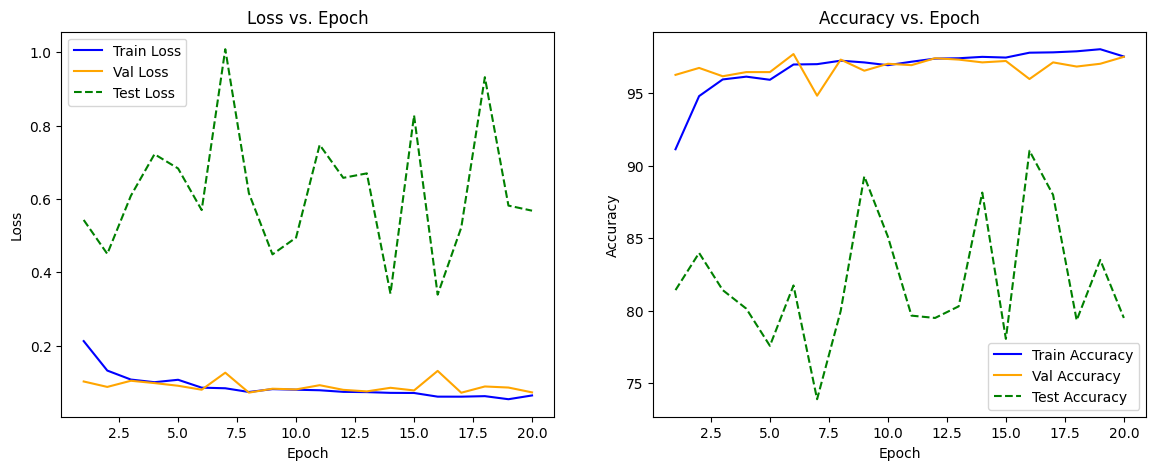

In [6]:
import matplotlib.pyplot as plt

# Plotting Training, Validation, and Test Loss & Accuracy
epochs = range(1, len(train_losses) + 1)  # Dynamically adjusting to the number of completed epochs

plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Val Loss', color='orange')
plt.plot(epochs, test_losses, label='Test Loss', color='green', linestyle='--')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='orange')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green', linestyle='--')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            # Store predictions and labels for later evaluation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Accuracy calculation
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate Accuracy
    accuracy = 100 * correct / total
    
    # Calculate Precision, Recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Print Classification Report
    print(f'\nAccuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}\n')
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=['Normal', 'Pneumonia']))

# Example usage for validation data
evaluate_model(model, dataloaders['val'], device)

# Example usage for test data
evaluate_model(model, dataloaders['test'], device)



Accuracy: 97.22%
Precision: 0.97
Recall: 0.97
F1-score: 0.97

Classification Report:

              precision    recall  f1-score   support

      Normal       0.97      0.92      0.95       285
   Pneumonia       0.97      0.99      0.98       759

    accuracy                           0.97      1044
   macro avg       0.97      0.96      0.96      1044
weighted avg       0.97      0.97      0.97      1044


Accuracy: 79.17%
Precision: 0.84
Recall: 0.79
F1-score: 0.77

Classification Report:

              precision    recall  f1-score   support

      Normal       0.98      0.45      0.62       234
   Pneumonia       0.75      0.99      0.86       390

    accuracy                           0.79       624
   macro avg       0.87      0.72      0.74       624
weighted avg       0.84      0.79      0.77       624

